# XGBoost

Import libraries. 

In [1]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_train_resampled.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_train_resampled.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_test.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_test.csv')

X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)


In [3]:
# display(y_test)
counts = y_test['VVR_group'].value_counts()
print(counts)

0    23
1    11
Name: VVR_group, dtype: int64


In [4]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Model with inner and outer split 

In [8]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe = RFE(estimator=DecisionTreeClassifier())
model = XGBClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__learning_rate': [0.1, 0.01],  # Learning rate
    'm__n_estimators': [50, 100, 200],  # Number of trees
    'm__max_depth': [3, 5, 8],  # Maximum depth of a tree
    'm__min_child_weight': [1, 5],  # Minimum sum of instance weight needed in a child
    's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_res.shape)
print(y_train_res.shape)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# evaluate_model(model, X_test, y_test)


NameError: name 'X_train_res' is not defined

# Optimized code 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns

In [8]:
def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)  # XGBoost classifier
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__learning_rate': [0.1, 0.01],  # Learning rate
        'classifier__n_estimators': [50, 100, 200],  # Number of trees
        'classifier__max_depth': [3, 5, 8],  # Maximum tree depth
        'classifier__min_child_weight': [1, 5],  # Minimum child weight
        'feature_selection__n_features_to_select': [5, 10, 20, 40, 80]  # Number of features to select with RFE
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred

Test scores for each fold: [0.64705882 0.67647059 0.85294118]
Fold 1 score: 0.647, SD: 0.091
Fold 2 score: 0.676, SD: 0.091
Fold 3 score: 0.853, SD: 0.091
The mean score using nested cross-validation is: 0.725 ± 0.091
Fold 1 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50, 'feature_selection__n_features_to_select': 80}
Fold 2 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50, 'feature_selection__n_features_to_select': 5}
Fold 3 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'feature_selection__n_features_to_select': 80}

Evaluating best model on test set

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23

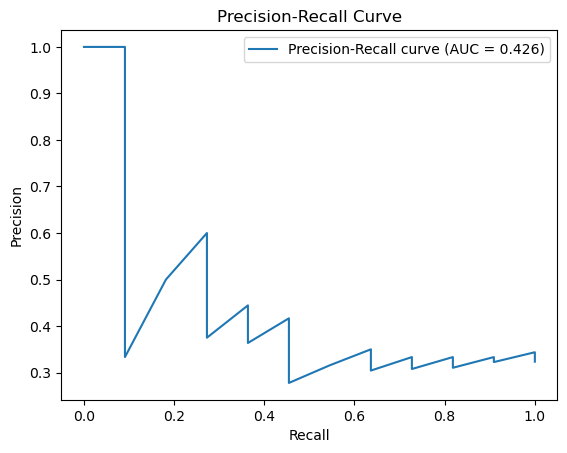

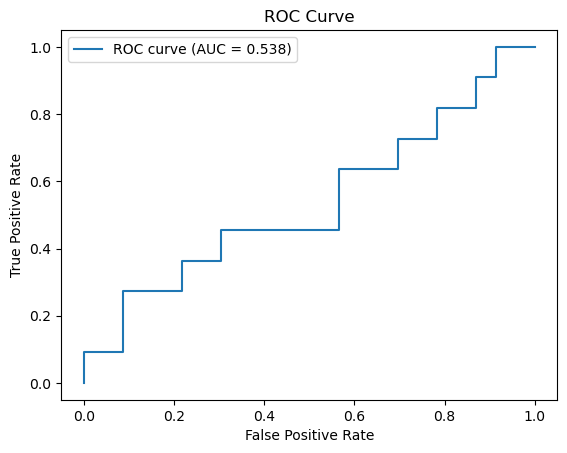

Test AUC-PR: 0.426


In [10]:
random_seed = 42

cv_results = perform_nested_cv(X_train, y_train, random_state=random_seed)  # Perform nested cross-validation
y_test_pred = evaluate_model(cv_results, X_test, y_test)  # Evaluate the model on the test set

# Confusion Matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_3966/1348981611.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Text(77.58333333333333, 0.5, 'Actual')

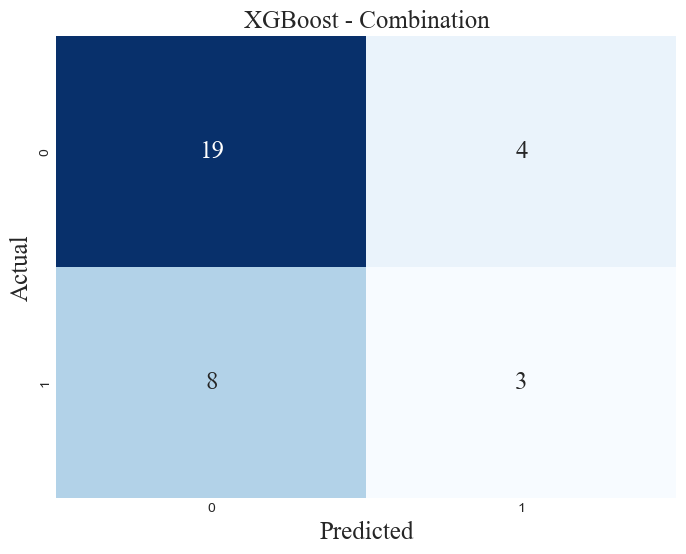

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('XGBoost - Combination', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)